In [1]:
import numpy as np
import sympy as sy
import matplotlib.pyplot as plt
import control.matlab as cm
from sympy import init_printing
init_printing()
%matplotlib notebook

In [2]:
%load_ext tikzmagic

## Control of a harddisk drive

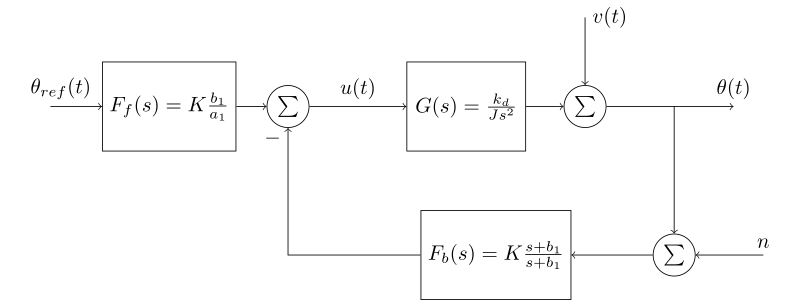

In [3]:
%%tikz --scale 2 --size 800,300 -f svg
\tikzset{node distance=2cm, 
    block/.style={rectangle, draw, minimum height=15mm, minimum width=20mm},
    sumnode/.style={circle, draw, inner sep=2pt}        
}

  \node[coordinate] (input) {};
  \node[block, right of=input] (TR) {$F_f(s)=K\frac{b_1}{a_1}$};
  \node[sumnode, right of=TR] (sum) {$\sum$};
  \node[block,right of=sum, node distance=30mm] (plant) {$G(s)=\frac{k_d}{Js^2}$};
  \node[sumnode, right of=plant] (sumdist) {$\sum$};
  \node[coordinate, above of=sumdist, node distance=15mm] (dist) {};
  \node[coordinate, right of=sumdist, node distance=15mm] (measure) {};
  \node[coordinate, right of=measure, node distance=10mm] (output) {};
  \node[sumnode,below of=measure, node distance=25mm] (sumnoise) {$\sum$};
  \node[coordinate, right of=sumnoise, node distance=15mm] (noise) {};
  \node[block,left of=sumnoise, node distance=30mm] (SR) {$F_b(s) = K\frac{s+b_1}{s+b_1}$};

  \draw[->] (input) -- node[above, pos=0.2] {$\theta_{ref}(t)$} (TR);
  \draw[->] (TR) -- node[above] {} (sum);
  \draw[->] (sum) -- node[above] {$u(t)$} (plant);
  \draw[->] (plant) -- (sumdist);
  \draw[->] (dist) -- node[at start, right] {$v(t)$} (sumdist);
  \draw[->] (sumdist) -- node[at end, above] {$\theta(t)$} (output);
  \draw[->] (measure) -- (sumnoise);
  \draw[->] (noise) -- node[at start, above] {$n$} (sumnoise);
  \draw[->] (sumnoise) -- (SR);
  \draw[->] (SR) -| (sum) node[left, pos=0.96] {$-$};


### Model
$$G(s) = \frac{k_d}{Js^2} = \frac{b}{s^2} $$ 
### 2DOF controller with
\begin{align}
F_f &= K \frac{b_1}{a_1}\\
F_b &= K \frac{s+b_1}{s+a_1}
\end{align}

### Characteristic equation
\begin{align}
A_c(s) = 1 + G(s)F_b(s) &= 0\\
1 + K\frac{b(s+b_1)}{s^2(s+a_1)} &= 0\\
s^3 + a_1s^2 + Kbs + Kbb_1 &= 0
\end{align}

### Desired closed-loop poles
$$ p_1 = -\omega_0, \quad p_2 = \omega_0(-0.5 + i\frac{\sqrt{3}}{2}) \quad p_2 = \omega_0(-0.5 - i\frac{\sqrt{3}}{2}) $$

In [4]:
s = sy.symbols('s')
a1,b1,kd,K,J = sy.symbols('a_1,b_1,k_d,K,J')
w0 = sy.symbols('omega0')

In [5]:
p1 = -w0
p2 = w0*(-0.5 + sy.I*sy.sqrt(3)/2)
p3 = w0*(-0.5 - sy.I*sy.sqrt(3)/2)
Ac = sy.collect(sy.expand((s-p1)*(s-p2)*(s-p3)), s)
Ac

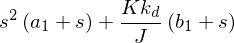

In [10]:
A = s**2
B = kd/J
R = s+a1
S = K*(s+b1)
lhs = A*R + B*S
lhs

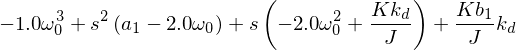

In [11]:
dioph = sy.collect(sy.expand(lhs-Ac), s)
dioph

### Finding the controller parameters
Setting the coefficients equal gives
\begin{align}
a_1 &= 2\omega_0\\
K &= \frac{2J\omega_0^2}{k_d}\\
b_1 &= \frac{\omega_0^3}{2\omega_0^2} = \frac{\omega_0}{2}
\end{align}

So, the feedback part of the controller is given by the filter with transfer function
$$ F_b(s) = \frac{2J\omega_0}{k_d} \cdot \frac{s + \frac{\omega_0}{2}}{s + 2\omega_0}$$

and the feedforward part is
$$ F_f(s) = \frac{2J\omega_0}{k_d} \cdot \frac{\frac{\omega_0}{2}}{2\omega_0} = \frac{J\omega_0}{2k_d}.$$


### Bode plot of the feedback filter

In [19]:
w0_n=1.0
J_n = 1.0
kd_n = 1.0
a1_n = 2*w0_n
b1_n = w0_n/2.0
K_n = 2*J_n*w0_n**2/kd_n
Fb = K_n*cm.tf([1, b1_n], [1, a1_n])
mag, phase, omega = cm.bode(Fb)
#plt.figure()
#mag, phase, omega = cm.bode(Fb)
#plt.figure()
#plt.loglog(mag, omega)

## Bodeplot of the loop gain

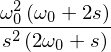

In [20]:
K = 2*J*w0**2/kd
a1 = 2*w0
b1 = w0/2
Fb = K*(s + b1)/(s+a1)
G = kd/J / s**2
Go = G*Fb
sy.simplify(sy.expand(Go))

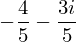

In [23]:
Go_at_w0 = Go.subs(s, sy.I*w0)
sy.simplify(Go_at_w0)

In [26]:
sy.Abs(sy.simplify(Go_at_w0))

In [31]:
sy.arg(sy.simplify(Go_at_w0)).evalf()*180/np.pi

<IPython.core.display.Javascript object>


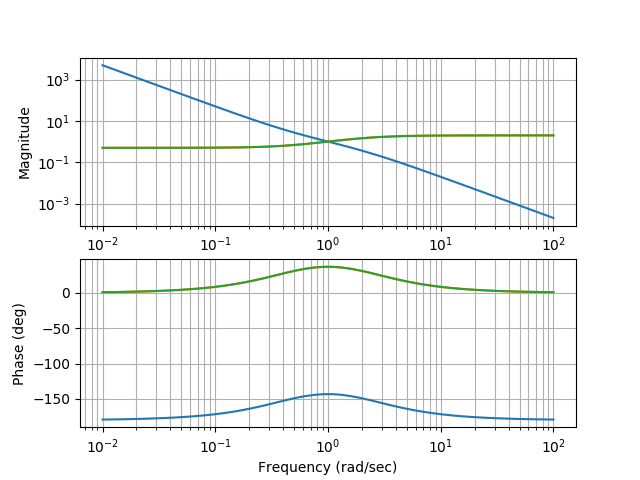

In [6]:
w0_n=1.0
J_n = 1.0
kd_n = 1.0
a1_n = 2*w0_n
b1_n = w0_n/2.0
K_n = 2*J_n*w0_n/kd_n
Fb = K_n*cm.tf([1, b1_n], [1, a1_n])
G = kd_n/J_n * cm.tf([1],[1, 0, 0])
plt.figure()
mag, phase, omega = cm.bode(Fb*G)


<IPython.core.display.Javascript object>


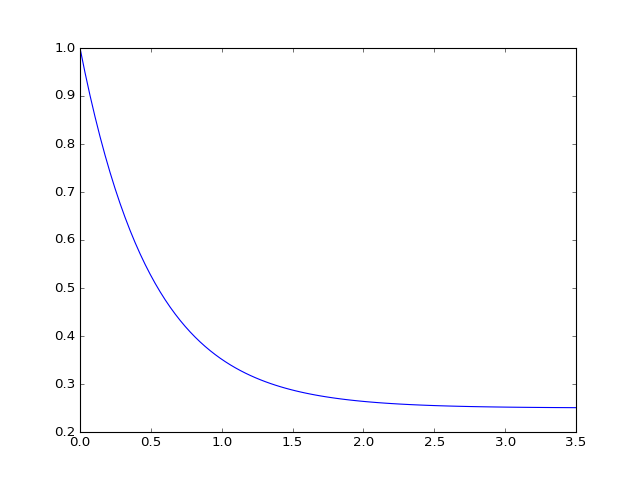

In [53]:
yout, tt = cm.step(Fb/K_n)
plt.figure()
plt.plot(tt, yout)

## Discretizing the controller
The control law is 
\begin{align} U(s) &= U_1(s) + U_2(s) = F_f(s)Y_{ref}(s) - F_b(s)Y(s)\\
 &= \underbrace{\frac{J\omega_0}{2k_d}Y_{ref}(s)}_{U_1(s)} \underbrace{- \frac{2J\omega_0}{k_d} \cdot \frac{s + 0.5\omega_0}{s + 2\omega_0} Y(s)}_{U_2(s)}
\end{align}
The first term is static, so it is straightforward to discretize
$$ u_1(t) = \frac{2J\omega_0}{k_d} y_{ref}(t) \quad \Rightarrow \quad u_1(kh) = \frac{2J\omega_0}{k_d}y_{ref}(kh). $$

The second term is
$$ U_2(s) = - \frac{2J\omega_0}{k_d} \cdot \frac{s + 0.5\omega_0}{s + 2\omega_0} Y(s) $$
$$ (s + 2\omega_0)U_2(s) = - \frac{2J\omega_0}{k_d} (s + 0.5\omega_0)Y(s) $$
Taking the inverse Laplace transform on each side of the equation we get the ODE
$$\dot{u}_2 + 2\omega_0u_2 = - \frac{2J\omega_0}{k_d} (\dot{y} + 0.5\omega_0 y)$$

In the computer we have to use a discrete approximation of the derivative. There are a number of different alternatives. The simplest is the Euler forward approximation
$$ \dot{x}(t) \approx \frac{x(t+h) - x(t)}{h} $$,
where $h$ is the sampling interval.
Using this approximation we get
$$ \dot{u}_2(kh) \approx \frac{u_2(kh+h) - u_2(kh)}{h} $$
$$ \dot{y}(kh) \approx \frac{y(kh+h) - y(kh)}{h} $$
and the linear ODE turns into the linear difference equation
$$ \frac{u_2(kh+h) - u_2(kh)}{h}  + 2\omega_0 u_2(kh) =  - \frac{2J\omega_0}{k_d} \left(\frac{y(kh+h) - y(kh)}{h} + 0.5\omega_0 y(kh) \right) $$

which can be written
$$ u_2(kh+h) = ( 1 - 2\omega_0h) u_2(kh) - \frac{2J\omega_0}{k_d}\left(y(kh+h) - (1+0.5\omega_0h)y(kh)\right). $$